## VOC Segmentation Dataset

In [1]:
from torchvision.datasets import voc
voc.DATASET_YEAR_DICT["2012"]["url"] = "http://data.brainchip.com/dataset-mirror/voc/VOCtrainval_11-May-2012.tar"

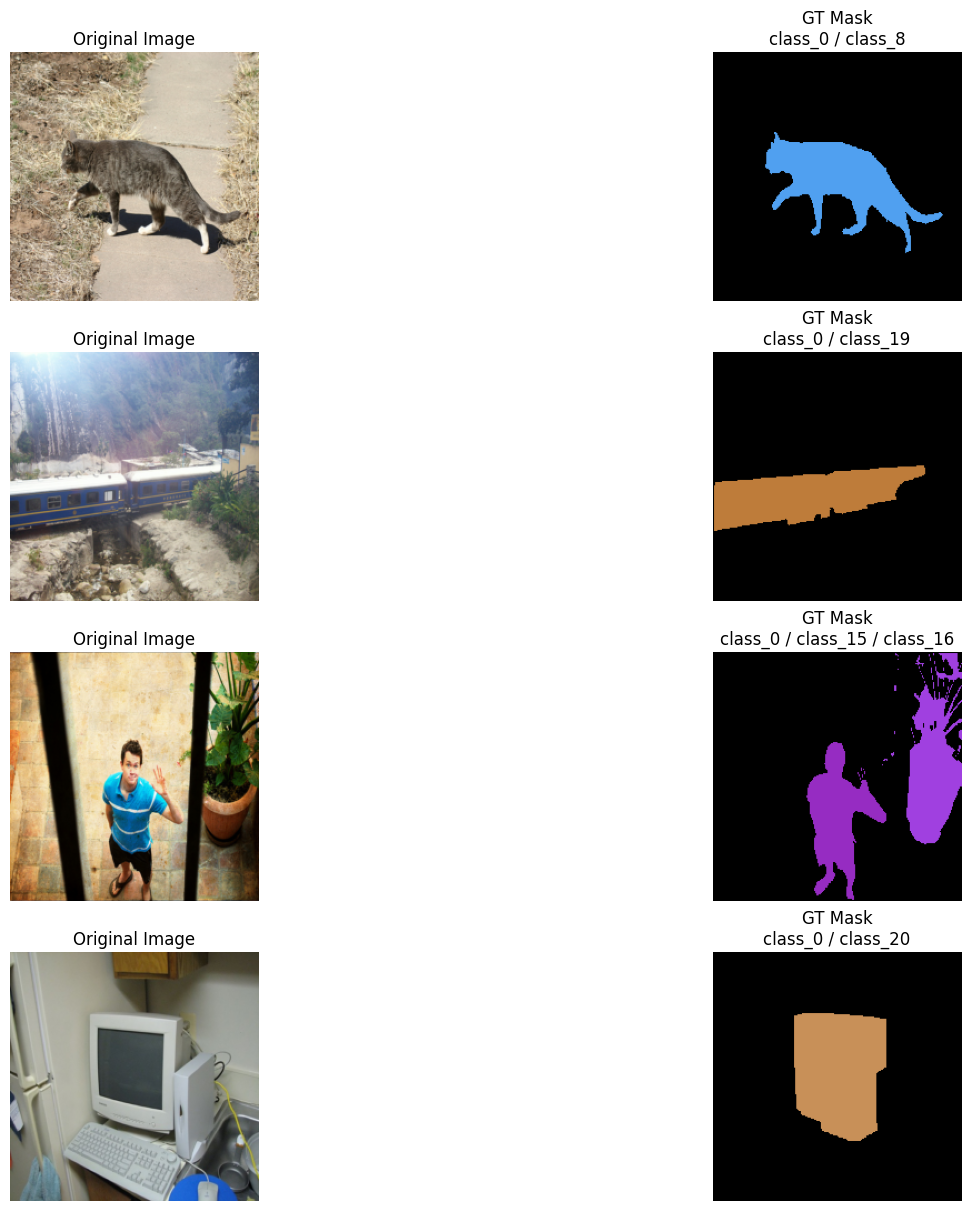

In [3]:
import os
import json
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

###############################################
# Step 1: VOCSegmentation 데이터셋 로드 및 클래스 정보 설정하기
###############################################
class SegmentationDataset(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        """
        VOCSegmentation 데이터셋을 로드하고, 이미지와 pixel-level segmentation mask를 반환하는 Dataset 클래스입니다.

        Args:
            root (str): 데이터셋이 저장될 루트 경로
            train (bool): True이면 training 데이터를, False이면 validation 데이터를 사용
            transform: 입력 이미지에 적용할 변환(예: 크기 조정, tensor 변환 등)
            target_transform: segmentation mask에 적용할 변환(보통 크기 조정 등, 클래스 값 보존을 위해 nearest interpolation 사용)
            download (bool): 데이터가 없으면 자동으로 다운로드할지 여부
        """
        # train이면 'train', 아니면 'val' 이미지를 선택합니다.
        image_set = 'train' if train else 'val'

        # torchvision의 VOCSegmentation 클래스를 사용하여 VOC 데이터셋을 불러옵니다.
        self.voc = datasets.VOCSegmentation(
            root=root,
            year='2012',
            image_set=image_set,
            download=download
        )

        # VOC 데이터셋 내의 클래스 정보를 담고 있는 JSON 파일 경로를 지정합니다.
        classes_json_path = os.path.join(root, "VOCdevkit", "VOC2012", "classes.json")
        if os.path.exists(classes_json_path):
            # JSON 파일이 있으면 불러와서 카테고리 정보를 저장합니다.
            with open(classes_json_path, "r") as file:
                self.categories = json.load(file)
        else:
            # JSON 파일이 없는 경우 기본값을 사용합니다.
            # 1번부터 21번까지의 클래스(보통 background가 0이고 1~20은 객체 클래스)를 만듭니다.
            self.categories = {str(i): {"class": f"class_{i}",
                                        "color": [i * 10 % 256, i * 20 % 256, i * 30 % 256]}
                               for i in range(1, 22)}
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        """
        주어진 index에 해당하는 이미지와 segmentation mask를 반환합니다.
        """
        # VOCSegmentation 객체로부터 image와 mask를 불러옵니다.
        image, mask = self.voc[index]

        # mask는 PIL.Image 형태로 로드되므로 numpy 배열로 변환하여 각 픽셀 값을 확인할 수 있습니다.
        mask = np.array(mask)

        # VOC 마스크에서는 255가 'ignore label'로 사용됩니다.
        # 모델 학습 시 ignore label은 보통 처리하지 않으므로, 여기서는 0 (배경)으로 대체합니다.
        mask = np.where(mask == 255, 0, mask)

        # numpy 배열을 파이토치의 LongTensor로 변환합니다.
        # unsqueeze(0)은 마스크에 채널 차원을 추가하여 (1, H, W) 형태로 만듭니다.
        target = torch.LongTensor(mask).unsqueeze(0)

        # 입력 이미지에 설정된 transform(예: 크기 조정, tensor 변환 등)을 적용합니다.
        if self.transform is not None:
            image = self.transform(image)
        # 마스크에도 target_transform이 있다면 적용합니다.
        if self.target_transform is not None:
            target = self.target_transform(target)
        return image, target

    def __len__(self):
        """
        데이터셋에 포함된 샘플의 총 개수를 반환합니다.
        """
        return len(self.voc)


###############################################
# Step 2: 이미지와 마스크에 적용할 전처리(Transform) 정의하기
###############################################
# 이미지 변환:
# 1. PIL 이미지를 tensor로 변환
# 2. tensor의 데이터 타입을 float로 변경
# 3. 이미지 크기를 (224, 224)로 조정
transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Resize((224, 224))
])

# 마스크 변환:
# 마스크는 정수값(클래스 id)을 가지므로, 크기 조정 시 nearest interpolation을 사용하여 값이 보존되도록 합니다.
target_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST)
])


###############################################
# Step 3: 데이터셋과 DataLoader 생성하기
###############################################
# 데이터셋 경로 (VOC 데이터셋의 루트 폴더)
root = "./data"

# train 데이터셋 생성 (필요시 download=True 옵션 사용)
train_dataset = SegmentationDataset(root, train=True, transform=transform, target_transform=target_transform, download=True)
# test 또는 validation 데이터셋 생성
test_dataset = SegmentationDataset(root, train=False, transform=transform, target_transform=target_transform, download=False)

# DataLoader 생성: 데이터를 배치 단위로 불러와 학습에 사용할 수 있도록 합니다.
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, drop_last=True)

###############################################
# Step 4: 시각화 함수 정의하기
###############################################
def draw_mask(images, masks, outputs=None, plot_size=4):
    """
    학습 중 또는 결과 확인을 위해, 이미지와 segmentation mask를 시각화합니다.

    Args:
        images (Tensor): 배치 이미지 (shape: [B, C, H, W])
        masks (Tensor): 배치 마스크 (shape: [B, 1, H, W])
        outputs (Tensor, optional): 예측 마스크 (있을 경우)
        plot_size (int): 시각화할 배치의 수
    """
    # 내부 함수: 마스크에 클래스별 색상을 입히는 함수
    def color_mask(image, target):
        # target: (1, H, W) 텐서를 squeeze하여 (H, W) 형태로 변경
        m = target.squeeze().numpy().astype(np.uint8)
        # image와 같은 크기를 가지는 빈 컬러 이미지를 생성 (H, W, 3)
        cm = np.zeros_like(image, dtype=np.uint8)
        # 클래스 1~20에 대해 색상 적용 (background는 0으로 남음)
        for i in range(1, 21):
            cm[m == i] = train_dataset.categories.get(str(i), {"color": [0, 0, 0]})["color"]
        # 마스크에 포함된 클래스 번호를 이용해 클래스 이름 리스트 생성
        classes = [train_dataset.categories.get(str(idx), {"class": f"class_{idx}"})["class"] for idx in np.unique(m)]
        return cm, classes

    # 출력할 열 수: 예측 결과(outputs)가 있으면 3, 없으면 2
    col = 3 if outputs is not None else 2
    # figsize: outputs가 있으면 8, 없으면 12 (원하는 크기에 맞춰 조절 가능)
    figsize = 8 if outputs is not None else 12
    fig, ax = plt.subplots(plot_size, col, figsize=(14, figsize), constrained_layout=True)

    for batch in range(plot_size):
        # 이미지 tensor를 numpy 배열로 변환 후, (C, H, W) -> (H, W, C) 형태로 전환
        im = images[batch].numpy().transpose(1, 2, 0)
        ax[batch][0].imshow(im)
        ax[batch][0].set_title("Original Image")
        ax[batch][0].axis("off")

        # 실제 마스크를 색칠한 결과
        cm, classes = color_mask(im, masks[batch])
        ax[batch][1].set_title("GT Mask\n" + " / ".join(classes))
        ax[batch][1].imshow(cm)
        ax[batch][1].axis("off")

        # 만약 예측 결과가 있다면 추가로 시각화
        if outputs is not None:
            cm, classes = color_mask(im, outputs[batch])
            ax[batch][2].set_title("Pred Mask\n" + " / ".join(classes))
            ax[batch][2].imshow(cm)
            ax[batch][2].axis("off")
    plt.show()


###############################################
# Step 5: DataLoader에서 한 배치 가져와 시각화하기
###############################################
# train DataLoader에서 한 배치를 가져옵니다.
images, masks = next(iter(train_dataloader))
# 첫 배치의 결과를 시각화하여 데이터 로드와 전처리 과정이 올바르게 작동하는지 확인합니다.
draw_mask(images, masks, plot_size=4)


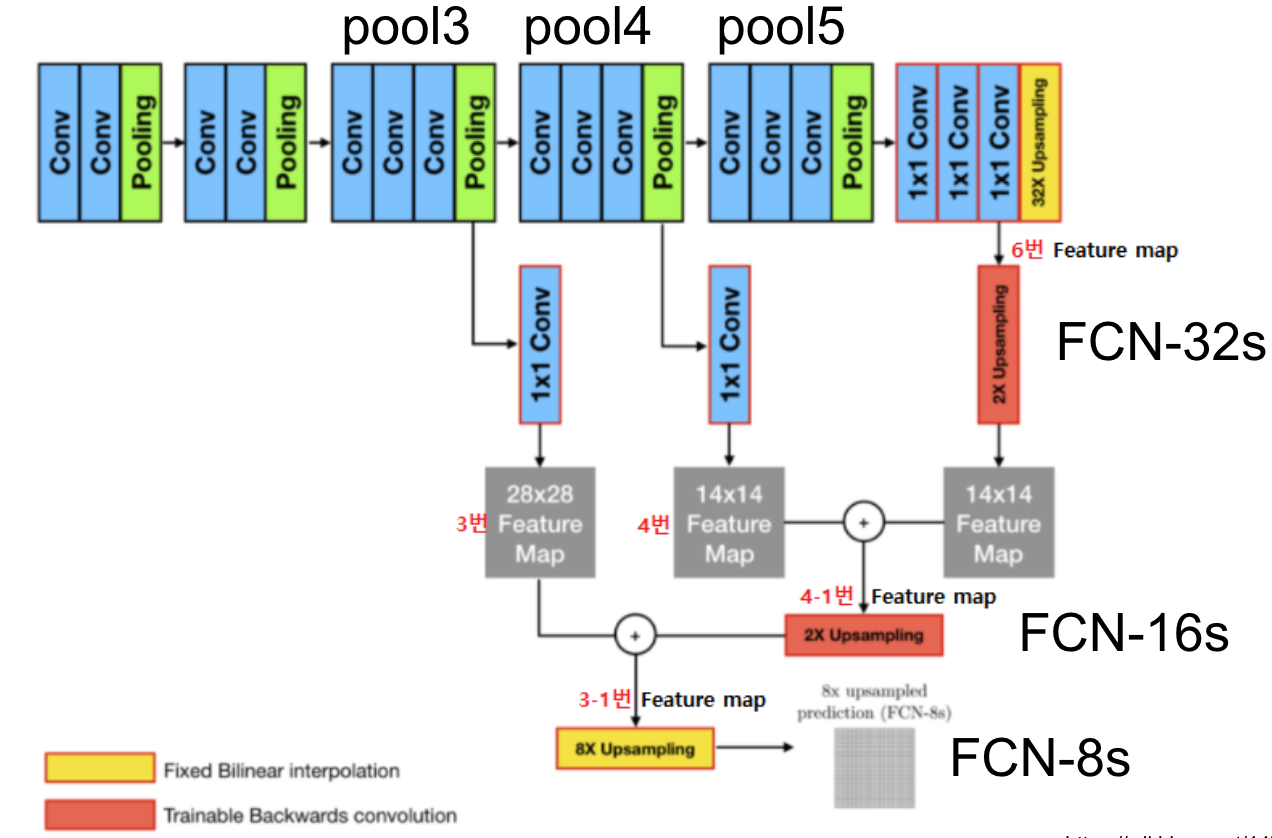

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np

from tqdm import tqdm

In [32]:
class FCN8s(nn.Module):
    def __init__(self, num_classes=21):
        super(FCN8s, self).__init__()
        vgg16 = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
        features = list(vgg16.features.children())

        # VGG16에서 중간 feature map 추출
        # pool3: features[0:17] (약 1/8 해상도)
        # pool4: features[17:24] (약 1/16 해상도)
        # pool5: features[24:]   (약 1/32 해상도)

        self.pool3 = nn.Sequential(*features[:17])
        self.pool4 = nn.Sequential(*features[17:24])
        self.pool5 = nn.Sequential(*features[24:])
        # 인자 언패킹 (Argument Unpacking)
        # 함수를 호출할 때 리스트 앞에 *를 붙이면,
        # 리스트 자체가 하나의 인자로 전달되는 것이 아니라,
        # 리스트 내부의 값들이 각각 별도의 위치 인자(Positional Argument)로 분리되어 전달

        # 1x1 convolution으로 각 feature map의 채널 수를 num_classes로 축소
        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.score_fr    = nn.Conv2d(512, num_classes, kernel_size=1)

        # Transposed convolution (upsampling) layers
        # O = (i-1) * S + K -2P

        # score_fr (1/32 해상도) -> upsample x2 -> 1/16 해상도
        # /// i*2+4-2 --> (7-1)*2+4-2 = 12+2 = 14
        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes,
                                           kernel_size=4,
                                           stride=2,
                                           padding=1,
                                           bias=False)
        # fuse_pool4 (1/16 해상도) -> upsample x2 -> 1/8 해상도
        # /// i*2+4-2 --> (14-1)*2+4-2 = 26+2 = 28
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes,
                                                kernel_size=4,
                                                stride=2,
                                                padding=1,
                                                bias=False)
        # fuse_pool3 (1/8 해상도) -> upsample x8 -> 원본 해상도
        # /// i*2+4-2 --> (28-1)*8+16-8 = 216+8 = 224
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes,
                                           kernel_size=16,
                                           stride=8,
                                           padding=4,
                                           bias=False)

    def forward(self, x):
        input_size = x.size()  # [B, C, H, W]
        pool3 = self.pool3(x)  # 1/8 해상도, 채널: 256
        pool4 = self.pool4(pool3)  # 1/16 해상도, 채널: 512
        pool5 = self.pool5(pool4)  # 1/32 해상도, 채널: 512

        score_fr = self.score_fr(pool5)  # [B, num_classes, H/32, W/32]
        upscore2 = self.upscore2(score_fr) # [B, num_classes, H/16, W/16]

        score_pool4 = self.score_pool4(pool4) # [B, num_classes, H/16, W/16]
        fuse_pool4 = upscore2 + score_pool4   # skip connection

        upscore_pool4 = self.upscore_pool4(fuse_pool4)  # [B, num_classes, H/8, W/8]

        score_pool3 = self.score_pool3(pool3)  # [B, num_classes, H/8, W/8]
        fuse_pool3 = upscore_pool4 + score_pool3 # skip connection

        upscore8 = self.upscore8(fuse_pool3)  # [B, num_classes, H, W]

        out = upscore8[:,:,:input_size[2], :input_size[3]]

        return out

In [33]:
num_classes = 21
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCN8s(num_classes=num_classes).to(device)

In [34]:
opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
loss_fn = nn.CrossEntropyLoss()

num_epochs=20
for epoch in range(num_epochs):
    model.train()
    running_loss =0.0
    for images, targets in tqdm(train_dataloader, desc=f"{epoch+1}/{num_epochs}"):
        images = images.to(device)
        targets = targets.to(device)  # target shape = [B, H, W]

        if targets.dim() == 4 and targets.size(1) == 1: # if [B, 1, H, W]
            targets =targets.squeeze(1) # [B, H, W] 이렇게 바꿔라

        opt.zero_grad()
        outputs = model(images) # output shape : [B, num_classes, H, W]
        loss = loss_fn(outputs, targets)
        loss.backward()
        opt.step()

        running_loss += loss.item()
    avg_loss = running_loss / len(train_dataloader)
    print(f"{epoch+1} loss {avg_loss:.4f}")

1/20: 100%|██████████| 366/366 [00:15<00:00, 23.52it/s]


1 loss 1.5544


2/20: 100%|██████████| 366/366 [00:15<00:00, 23.96it/s]


2 loss 1.1771


3/20: 100%|██████████| 366/366 [00:15<00:00, 24.36it/s]


3 loss 1.1443


4/20: 100%|██████████| 366/366 [00:15<00:00, 24.20it/s]


4 loss 1.0984


5/20: 100%|██████████| 366/366 [00:15<00:00, 23.91it/s]


5 loss 1.0451


6/20: 100%|██████████| 366/366 [00:15<00:00, 23.39it/s]


6 loss 0.9851


7/20: 100%|██████████| 366/366 [00:15<00:00, 23.51it/s]


7 loss 0.9620


8/20: 100%|██████████| 366/366 [00:15<00:00, 23.10it/s]


8 loss 0.9245


9/20: 100%|██████████| 366/366 [00:15<00:00, 23.11it/s]


9 loss 0.8934


10/20: 100%|██████████| 366/366 [00:15<00:00, 23.60it/s]


10 loss 0.8631


11/20: 100%|██████████| 366/366 [00:15<00:00, 24.17it/s]


11 loss 0.8339


12/20: 100%|██████████| 366/366 [00:15<00:00, 23.20it/s]


12 loss 0.8084


13/20: 100%|██████████| 366/366 [00:15<00:00, 23.51it/s]


13 loss 0.7786


14/20: 100%|██████████| 366/366 [00:15<00:00, 23.23it/s]


14 loss 0.7542


15/20: 100%|██████████| 366/366 [00:15<00:00, 23.25it/s]


15 loss 0.7390


16/20: 100%|██████████| 366/366 [00:15<00:00, 23.00it/s]


16 loss 0.7210


17/20: 100%|██████████| 366/366 [00:15<00:00, 23.65it/s]


17 loss 0.6904


18/20: 100%|██████████| 366/366 [00:15<00:00, 24.03it/s]


18 loss 0.6740


19/20: 100%|██████████| 366/366 [00:16<00:00, 22.83it/s]


19 loss 0.6564


20/20: 100%|██████████| 366/366 [00:15<00:00, 23.26it/s]

20 loss 0.6293


In [35]:
torch.save(model.state_dict(), './models/fcn-8.pth')

In [36]:
model_loaded = FCN8s(num_classes=num_classes).to(device)
model_state_dict = torch.load('./models/fcn-8.pth')
model_loaded.load_state_dict(model_state_dict)

<All keys matched successfully>

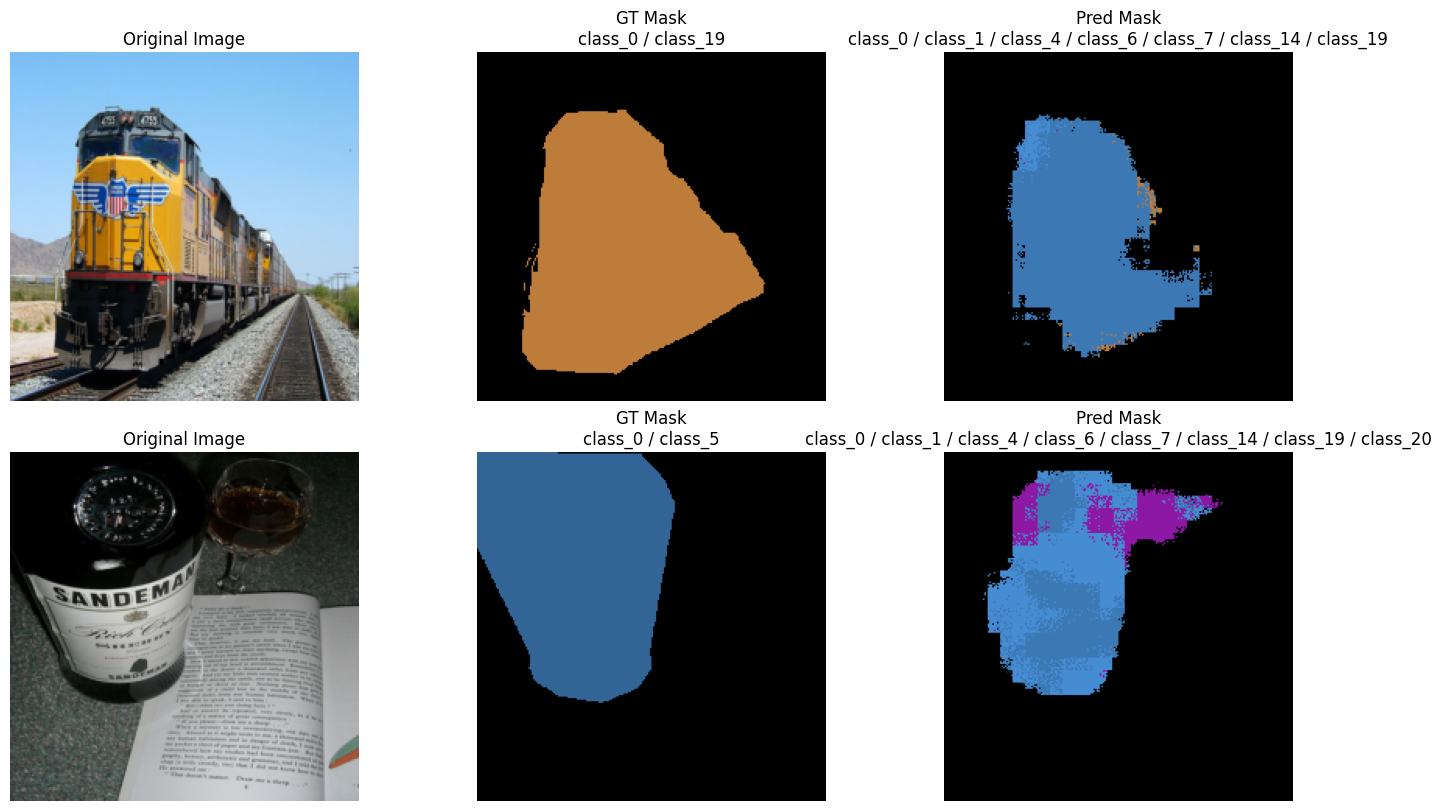

In [40]:
with torch.no_grad():
    model.eval()
    images, masks = next(iter(test_dataloader))
    outputs = model(images.to(device))
    outputs = outputs.argmax(dim=1).to('cpu')
    draw_mask(images, masks, outputs, 2)